In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision
# from imutils import paths
import cv2
import os
from sklearn.model_selection import train_test_split, KFold
from torchsummary import summary

In [7]:

c_dataset_path = 'D:/Uni/Cap-Project/MetaPics/MetaHumanTest_transformed'
c_image_paths = sorted(list(map(lambda x: os.path.join(c_dataset_path,x), filter(lambda x: x not in ['', '.DS_Store'], os.listdir(c_dataset_path)))))

TEST_SPLIT_MH = 0.02
TEST_SPLIT_C = 0.1
BATCH_SIZE = 64
INPUT_IMAGE_HEIGHT = 70
INPUT_IMAGE_WIDTH = 210 

device = torch.device('cuda')

def itr_merge(*itrs):
    for itr in itrs:
        yield from itr

In [8]:
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])

class EyeDataset(Dataset):
	def __init__(self, imagePaths, MH, transforms=None, bw=False):
		self.imagePaths = imagePaths
		self.images = []
		self.transforms = transforms
		for idx, imagePath in enumerate(self.imagePaths):
			# load the image from disk, swap its channels from BGR to RGB,
			# and read the associated mask from disk in grayscale mode
			image = cv2.imread(imagePath)
			if bw:
				image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
			res = imagePath.split('/')[-1].split('.jpg')[0].split('_')
			if MH:
				pitch = -float(res[2][:-1])
				yaw = -float(res[3][:-1])
			else:
				pitch = float(res[2][:-1]) # eye pitch
				yaw = float(res[3][:-1]) # eye yaw
			hp = res[4] # head pitch degree
			hr = res[5] # head roll
			hy = res[6] # head yaw
			head_pos = torch.tensor([float(hp), float(hr), float(hy)], dtype=torch.float32)
			res = [float(pitch), float(yaw)]
			res = torch.tensor(res, dtype=torch.float32)
			# check to see if we are applying any transformations
			if self.transforms is not None:
				image = self.transforms(image)

			self.images.append(((image, head_pos), res))
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.images)
	def __getitem__(self, idx):
		return ((self.images[idx][0][0].to(device), self.images[idx][0][1].to(device)), self.images[idx][1].to(device))

In [9]:
#COLUMNBIA DATASET
(mainImagesC, testImagesC) = train_test_split(c_image_paths, test_size=TEST_SPLIT_C, random_state=42)
(trainImagesC, valImagesC) = train_test_split(mainImagesC, test_size=TEST_SPLIT_C, random_state=42)

# create the train and test datasets
trainDSC = EyeDataset(imagePaths=trainImagesC, transforms=transforms, MH=False)
valDSC = EyeDataset(imagePaths=valImagesC, transforms=transforms, MH=False)
testDSC = EyeDataset(imagePaths=testImagesC, transforms=transforms, MH=False)

print(f"[INFO] found {len(trainDSC)} examples in Columbia the training set...")
print(f"[INFO] found {len(valDSC)} examples in Columbia the validation set...")
print(f"[INFO] found {len(testDSC)} examples in Columbia the test set...")

# create the training and test data loaders
trainLoaderC = DataLoader(trainDSC, shuffle=False,
	batch_size=BATCH_SIZE, num_workers=0)
valLoaderC = DataLoader(valDSC, shuffle=False,
	batch_size=1, num_workers=0)
testLoaderC = DataLoader(testDSC, shuffle=False,
	batch_size=1, num_workers=0)

[INFO] found 9525 examples in Columbia the training set...
[INFO] found 1059 examples in Columbia the validation set...
[INFO] found 1176 examples in Columbia the test set...


In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [11]:
class SixthEyeNet(nn.ModuleList):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 9, 3)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(9, 26, 3)
        self.fc1 = nn.Linear(3432, 600)
        self.fc2 = nn.Linear(600, 50)
        self.fc3 = nn.Linear(53, 2)

    def forward(self, x):
        x, head_pos = x
        head_pos = head_pos
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.cat((x, head_pos), 1) # inject head pos
        x = self.fc3(x)
        return x

In [12]:
def create_network():
    net = SixthEyeNet()

    net.to(device)

    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    return net, criterion, optimizer

net, criterion, optimizer = create_network()

In [13]:
every = 50
training_epoch_loss = []
validation_epoch_loss = []
for epoch in range(120):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainLoaderC, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data # input = (image, head_pos), labels = res

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics

        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % every == every - 1:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / every:.3f}')
            running_loss = 0.0
    losses = []
    with torch.no_grad():
        for data in valLoaderC:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            losses.append(criterion(outputs, labels).item())
    training_epoch_loss.append(epoch_loss/len(trainLoaderC))
    validation_epoch_loss.append(sum(losses)/len(losses))
    print(f'Accuracy of the network on the validation images: {max(losses)}, {min(losses)}, {sum(losses)/len(losses)}')

print('Finished Training')

[1,    50] loss: 83.570
[1,   100] loss: 71.339
Accuracy of the network on the validation images: 332.80975341796875, 0.18149492144584656, 60.145230933643944
[2,    50] loss: 55.777
[2,   100] loss: 54.988
Accuracy of the network on the validation images: 376.95513916015625, 0.020865367725491524, 51.16888535634999
[3,    50] loss: 47.910
[3,   100] loss: 46.987
Accuracy of the network on the validation images: 341.984619140625, 0.01187955029308796, 42.93492676687055
[4,    50] loss: 41.023
[4,   100] loss: 39.441
Accuracy of the network on the validation images: 286.00701904296875, 0.001827804371714592, 35.4519164383225
[5,    50] loss: 33.684
[5,   100] loss: 31.866
Accuracy of the network on the validation images: 288.07586669921875, 0.051137275993824005, 29.184239835102847
[6,    50] loss: 27.103
[6,   100] loss: 25.505
Accuracy of the network on the validation images: 299.8443603515625, 0.011333671398460865, 24.939319975689102
[7,    50] loss: 22.505
[7,   100] loss: 21.228
Accurac

In [15]:
PATH = './models/sixth_eye_net_combined.pth'
net.to('cpu')
torch.save(net.state_dict(), PATH)

In [16]:
net.load_state_dict(torch.load(PATH))
net.to(device='cpu')

/var/folders/hc/x5f5kd3s527g6tz2z9zkftv00000gn/T/ipykernel_93598/3913192997.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


SixthEyeNet(
  (0): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(9, 26, kernel_size=(3, 3), stride=(1, 1))
  (3): Linear(in_features=3432, out_features=600, bias=True)
  (4): Linear(in_features=600, out_features=50, bias=True)
  (5): Linear(in_features=53, out_features=2, bias=True)
)

In [17]:
losses = []
criterion2 = nn.L1Loss().to(device)
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testLoaderC:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        losses.append(criterion2(outputs, labels))

        
print(f'Accuracy of the network on the test images: {max(losses)}, {min(losses)}, {sum(losses)/len(losses)}')
# Accuracy of the network on the test images: 11.710856437683105, 0.05646705627441406, 1.7454159259796143


Accuracy of the network on the test images: 16.18828773498535, 0.0618133544921875, 2.8329410552978516


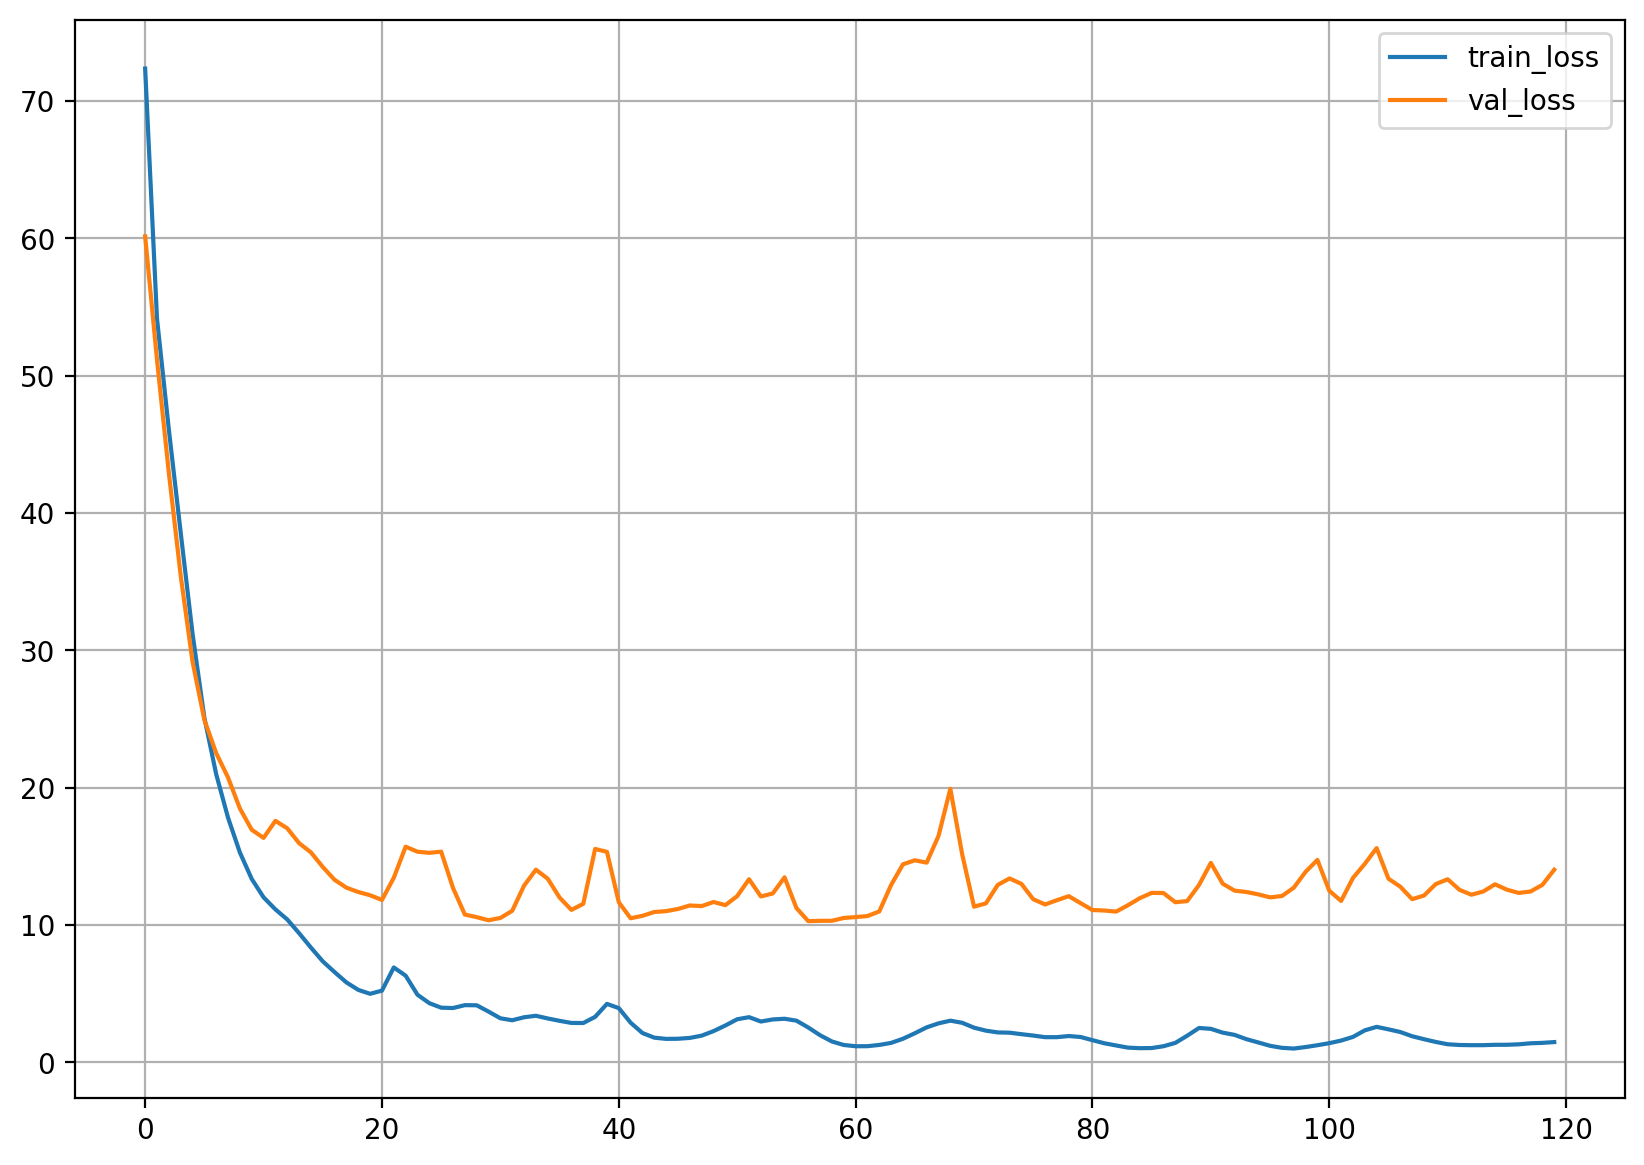

In [18]:
def plot_train_val_loss(training_losses, validation_losses):
    plt.figure(figsize=(10, 7))
    plt.grid()
    plt.plot(training_losses, label='train_loss')
    plt.plot(validation_losses, label='val_loss')
    plt.legend()
    plt.show()

plot_train_val_loss(training_epoch_loss, validation_epoch_loss)